In [1]:
import sys
sys.path.append('../../../')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

from scipy.stats import chi2, multivariate_normal

from LRM.plotting import set_plot_style
from LRM.CMP1D import CMP1D, SmoothedEmpiricalDensity1D

set_plot_style()

SAVE = True

# Helpers

In [8]:
def transform_logtheta_theta(mu_X, Sigma_X):

    mu1, mu2 = mu_X.flatten()
    sigma11, sigma12 = Sigma_X[0, 0], Sigma_X[0, 1]
    sigma22 = Sigma_X[1, 1]

    # Compute E[theta1] = E[exp(x1)]
    E_theta1 = np.exp(mu1 + 0.5 * sigma11)

    # Mean vector
    mu_Y = np.array([
        E_theta1,
        mu2
    ])

    # Variance of exp(x1)
    var_theta1 = (np.exp(sigma11) - 1) * np.exp(2 * mu1 + sigma11)

    # Covariance between exp(x1) and x2
    cov_theta1_theta2 = np.exp(mu1 + 0.5 * sigma11) * sigma12

    # Covariance matrix
    Sigma_Y = np.array([
        [var_theta1,             cov_theta1_theta2],
        [cov_theta1_theta2,      sigma22]
    ])

    return mu_Y.reshape(-1,1), Sigma_Y


def transform_theta_logtheta(mu_X, Sigma_X):

    mu_X = np.asarray(mu_X)
    Sigma_X = np.asarray(Sigma_X)

    theta1, theta2 = mu_X
    if theta1 <= 0:
        raise ValueError("theta1 must be positive for log transformation.")

    # g(mu_X)
    mu_Y = np.array([np.log(theta1), theta2])

    # Jacobian of g at mu_X
    J = np.array([
        [1/theta1, 0],
        [0,        1]
    ])

    # Covariance after transformation
    Sigma_Y = J @ Sigma_X @ J.T

    return mu_Y.reshape(-1,1), Sigma_Y

In [9]:
def get_mean_cov(i, theta1, theta2, method):

    file = lambda method : f"./outputs/{method}_theta1={theta1}_theta2={theta2}_numboot=100_dnum=2000_pnum=5000_data=dataset{i}_samples.npy"
    post_sample = np.load(file(method))

    return post_sample.mean(axis=0), np.cov(post_sample.T)


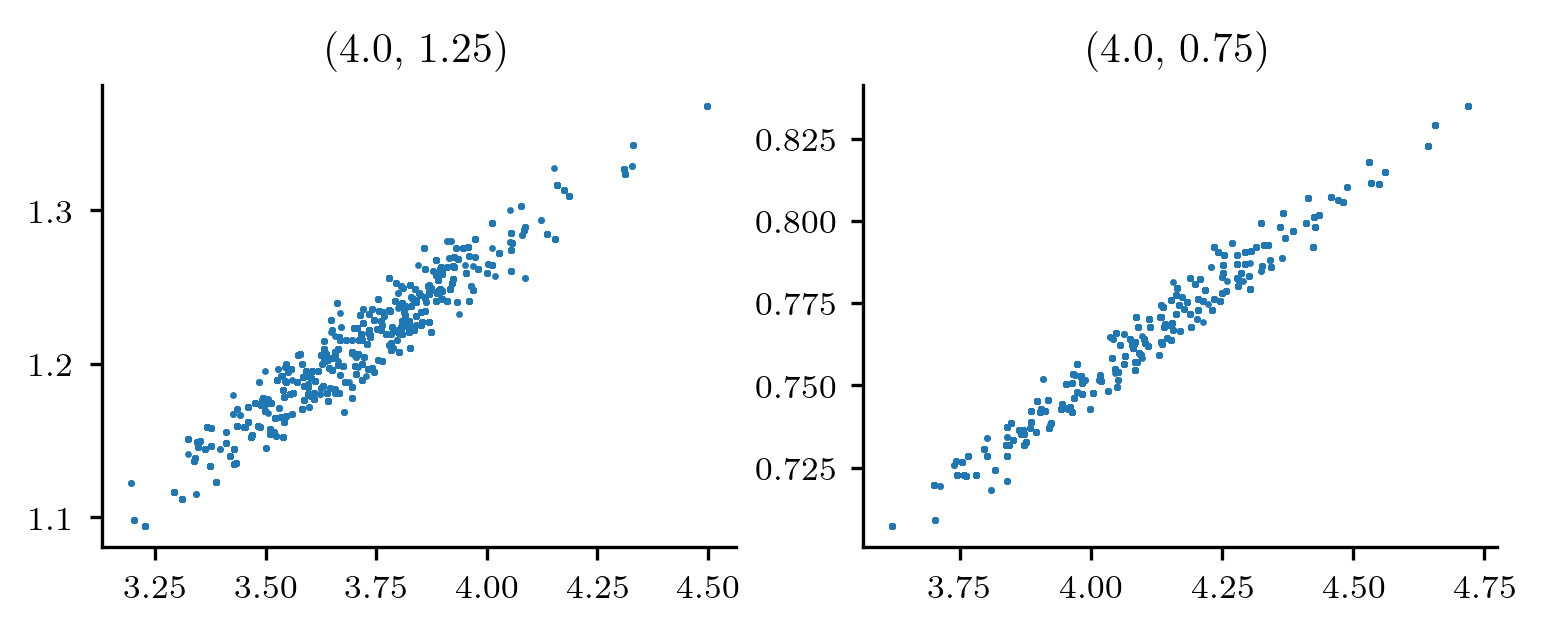

In [10]:
#We quickly show that Bayes posteriors are Gaussian-looking
Bayes_posterior_samples_under = np.load("./outputs/Bayes_theta1=4.0_theta2=0.75_numboot=100_dnum=2000_pnum=5000_data=dataset2_samples.npy")
Bayes_posterior_samples_over = np.load("./outputs/Bayes_theta1=4.0_theta2=1.25_numboot=100_dnum=2000_pnum=5000_data=dataset2_samples.npy")

fig, axs = plt.subplots(1, 2, figsize=(6, 2))
axs[0].scatter(Bayes_posterior_samples_over[:, 0], Bayes_posterior_samples_over[:, 1], s=0.4)
axs[1].scatter(Bayes_posterior_samples_under[:, 0], Bayes_posterior_samples_under[:, 1], s=0.4)
axs[0].set_title("(4.0, 1.25)"); axs[1].set_title("(4.0, 0.75)");

In [11]:
def plot_gaussian_ellipse(mean, cov, ax, confidence=0.95, style='solid', label=None, color='black'):
    # Compute the ellipse corresponding to the confidence level
    chi2_val = chi2.ppf(confidence, df=2)
    
    # Eigen-decomposition for ellipse axes
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    # Compute width and height of ellipse
    width, height = 2 * np.sqrt(vals * chi2_val)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor='none', linestyle=style, linewidth=1.7, label=label)
    ax.add_patch(ellipse)

# Comparison

[scipy] beta*: 0.557907, coverage: 0.9400 (target 0.9500); fun=0.0001, success=True
[scipy] beta*: 1.38003, coverage: 0.9200 (target 0.9500); fun=0.0009, success=True
time at n=2000, 1000 MCMC samples for FDBayes 131.48901200294495
time at n=2000, 5000 MCMC samples for FDBayes 135.20201802253723
time at n=2000, 1000 MCMC samples for Bayes 0.4518925428390503
time at n=2000, 5000 MCMC samples for Bayes 2.247460722923279
time at n=2000 for LRM 0.018532729148864745


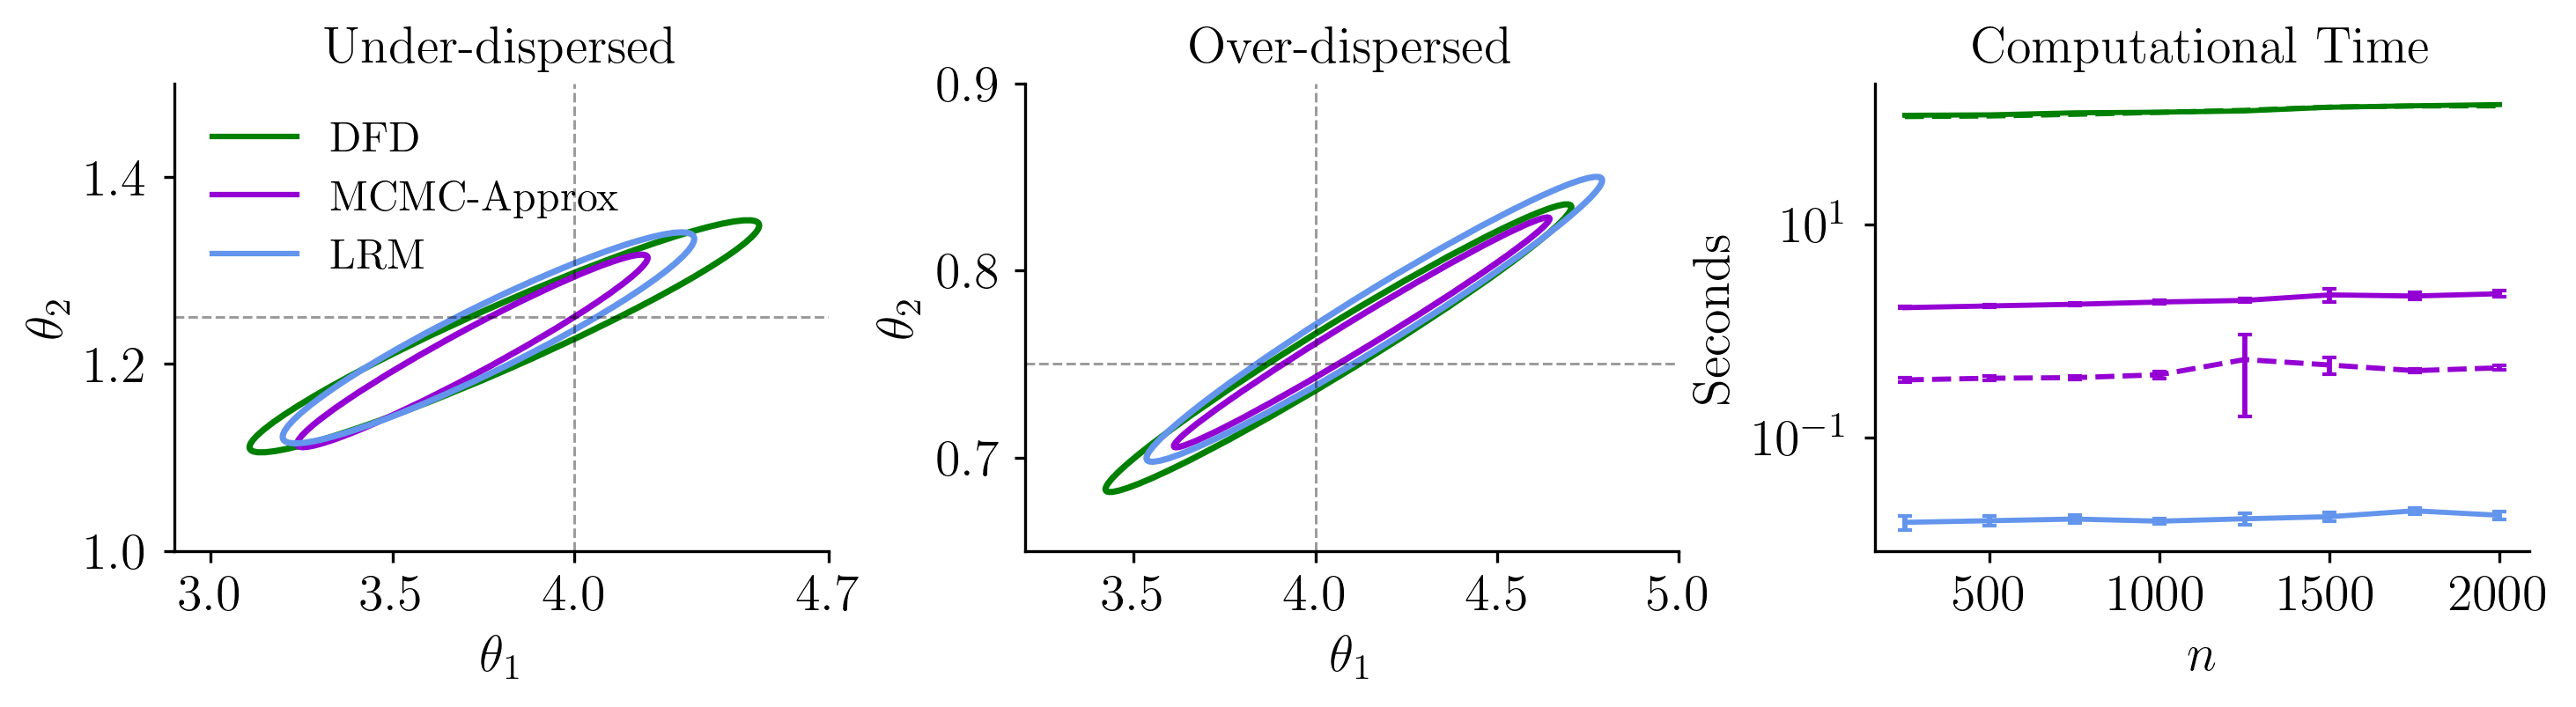

In [12]:
plt.rcParams.update({'font.size': 15})

prior = multivariate_normal(mean=[3.0, 3.0], cov=[[1.0, 0.0], [0.0, 1.0]])
prior_mean, prior_cov = transform_theta_logtheta(prior.mean, prior.cov)

# Create a grid of (x, y) points
x, y = np.mgrid[2.8:5:.001, 1.:1.5:.001]
pos = np.dstack((x, y))

# Plot the contour for each Gaussian
fig, axs = plt.subplots(1, 3, figsize=(11.5, 2.3), gridspec_kw={'width_ratios': [1, 1, 1]})

styles = ['solid', 'solid', 'solid']
labels = ['DFD', 'MCMC-Approx', 'LRM']
methods = ["FDBayes", "Bayes", "LRM"]
colors = ["green", "darkviolet", "cornflowerblue"]

i = 2
theta1 = 4.0


for ax_idx, theta2 in enumerate([1.25, 0.75]):
    for method, style, label, color in zip(methods, styles, labels, colors):
        
        if method == 'LRM':
            data = np.load(f"./outputs/dataset{i}_theta1={theta1}_theta2={theta2}.npy").flatten()

            empirical = SmoothedEmpiricalDensity1D(alpha=0.0)
            empirical.fit(data)

            cmp = CMP1D(empirical=empirical)

            beta, _, _ = cmp.fit_coverage(data=data, prior_mean=prior_mean, prior_cov=prior_cov, verbose=True, B=50)

            posterior = cmp.posterior(data, beta=beta, mu_prior=prior_mean, Sigma_prior=prior_cov)

            mean, cov = transform_logtheta_theta(posterior.mean, posterior.cov)

        else:
            mean, cov = get_mean_cov(i, theta1, theta2, method)
            
        plot_gaussian_ellipse(mean.flatten(), cov, axs[ax_idx], confidence=0.95, style=style, label=label, color=color)


legend_lines = [
    Line2D([1], [1], color=color, linestyle=ls, linewidth=1.5, label=lbl)
    for ls, lbl, color in zip(styles, labels, colors)
]

ymin, ymax = 1., 1.5
xmin, xmax = 2.9, 4.7
lw = 0.7

axs[0].vlines(4.0, ymin, ymax, color='black', alpha=0.4, linestyles='--', linewidths=lw)
axs[0].hlines(1.25, xmin, xmax, color='black', alpha=0.4, linestyles='--', linewidths=lw)
axs[0].set_ylim(1, 1.5)
axs[0].set_xlim(xmin, xmax)

ymin, ymax = 0.65, 0.9
xmin, xmax = 3.2, 5.
axs[1].vlines(4.0, ymin, ymax, color='black', alpha=0.4, linestyles='--', linewidths=lw)
axs[1].hlines(0.75, xmin, xmax, color='black', alpha=0.4, linestyles='--', linewidths=lw)
axs[1].set_ylim(ymin, ymax)
axs[1].set_xlim(xmin, xmax)


axs[0].legend(handles=legend_lines, fontsize=11.5, ncols=1, frameon=False, loc='upper left')

for i in range(2):
    axs[i].set_xlabel(r'$\theta_1$', fontsize=14)
    axs[i].set_ylabel(r'$\theta_2$', fontsize=14)

axs[0].set_title("Under-dispersed", fontsize=14)
axs[1].set_title("Over-dispersed", fontsize=14)

for arg, linestyle, color in zip(["FDBayes", "Bayes", "LRM"], styles, colors):

    if arg in ["FDBayes", "Bayes"]:
        d1000 = np.load(f'./outputs/computation_{arg}_theta1=4.0_theta2=1.25_numMCMCsamples=1000.npz')
        d5000 = np.load(f'./outputs/computation_{arg}_theta1=4.0_theta2=1.25_numMCMCsamples=5000.npz')


        times1000 = d1000["times_total"]
        times5000 = d5000["times_total"]

        print(f"time at n=2000, 1000 MCMC samples for {arg}", np.mean(times1000, axis=1)[-1])
        print(f"time at n=2000, 5000 MCMC samples for {arg}", np.mean(times5000, axis=1)[-1])

        if arg == "FDBayes":
            axs[2].plot(d1000["n"], times1000.mean(axis=1), linestyle='dashed', markersize=4, color=color, linewidth=2*lw)
            axs[2].plot(d5000["n"], times5000.mean(axis=1), linestyle='solid', markersize=4, color=color, linewidth=2*lw)
    
    
        else:
            axs[2].errorbar(d1000["n"], times1000.mean(axis=1), yerr=times1000.std(axis=1), color=color, linestyle='dashed', linewidth=2*lw, capsize=2)
            axs[2].errorbar(d5000["n"], times5000.mean(axis=1), yerr=times5000.std(axis=1), color=color, linestyle='solid', linewidth=2*lw, capsize=2)
        
    else:
        d = np.load(f'./outputs/computation_{arg}_theta1=4.0_theta2=1.25.npz')
        times = d["times_total"]
        print(f"time at n=2000 for {arg}", np.mean(times, axis=1)[-1])

        axs[2].errorbar(d["n"], times.mean(axis=1), yerr=times.std(axis=1), color=color, linestyle=linestyle, linewidth=2*lw, capsize=2)
        

axs[2].set_yscale('log')

axs[2].set_title("Computational Time", fontsize=14)
axs[2].set_ylabel("Seconds", fontsize=14)
axs[2].set_xlabel(r"$n$", fontsize=14)

for i in range(3): 
    axs[i].tick_params(axis='both', labelsize=14)

fig.subplots_adjust(wspace=0.3)

axs[0].set_xticks([3.0, 3.5, 4.0, 4.7])

if SAVE:
    plt.savefig("./results/CMP-univariate-comparison.pdf", format="pdf", bbox_inches='tight')